# Support for spatial transcriptomics

For more information on the support for spatial transcriptomics, please see the [SPArrOW documentation](https://sparrow-pipeline.readthedocs.io/en/latest). Harpy focusses on the analysis of spatial proteomics data and extends the SPArrOW pipeline to support highly-multiplexed images.

In this notebook, we will work with mouse liver spatial transcriptomics data generated using [Resolve Biosciences’ Molecular Cartography technology](https://www.resolvebiosciences.com/).

In [1]:
# To run this notebook with CUDA, install dask-cuda:
#    uv pip install dask-cuda==24.12.0
#
# We pin to this version because spatialdata requires
# dask>=2024.10.0,<=2024.11.2, and dask-cuda 24.12.0
# is the latest release compatible with that range.

import harpy as hp

## 1. Read in the data

The first step includes reading in the raw data.

The example dataset for this notebook will be downloaded and cached using `pooch` via `harpy.dataset.registry`.


### Convert to zarr and read the image


In [2]:
import os
import tempfile
import uuid

from spatialdata import SpatialData
from spatialdata import read_zarr

from harpy.datasets.registry import get_registry

from spatialdata.transformations import Scale, Identity

from dask_image import imread

# change this path. It is the directory where the spatialdata .zarr will be saved.
OUTPUT_DIR = tempfile.gettempdir()

img_layer = "raw_image"

path = None  # If None, example data will be downloaded in the default cache folder of your os. Set this to a custom path, to change this behaviour.
registry = get_registry(path=path)
path_image = registry.fetch("transcriptomics/resolve/mouse/20272_slide1_A1-1_DAPI.tiff")

# you can choose any name for your zarr file
output_path = os.path.join(OUTPUT_DIR, f"sdata_{uuid.uuid4()}.zarr")

sdata = SpatialData()
sdata.write(output_path)
sdata = read_zarr(sdata.path)

arr = imread.imread(path_image)

# we will add the image in the micron and pixel coordinate system
pixel_size = 0.138  # pixel size in micron for resolve

scale = Scale(axes=["x", "y"], scale=[pixel_size, pixel_size])

sdata = hp.im.add_image_layer(
    sdata,
    arr=arr.rechunk(1024),
    output_layer=img_layer,
    transformations={"pixel": Identity(), "micron": scale},
    scale_factors=[2, 2, 2, 2],
    c_coords="DAPI",
)
sdata

/Users/arnedf/VIB/harpy/.venv_harpy/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
2025-11-19 20:54:19,633 - harpy.image._manager - INFO - Writing results to layer 'raw_image'


SpatialData object, with associated Zarr store: /private/var/folders/q5/7yhs0l6d0x771g7qdbhvkvmr0000gp/T/sdata_21e9705d-6c32-4296-b47c-b06327941efa.zarr
└── Images
      └── 'raw_image': DataTree[cyx] (1, 12864, 10720), (1, 6432, 5360), (1, 3216, 2680), (1, 1608, 1340), (1, 804, 670)
with coordinate systems:
    ▸ 'micron', with elements:
        raw_image (Images)
    ▸ 'pixel', with elements:
        raw_image (Images)

## 2. Plot the image


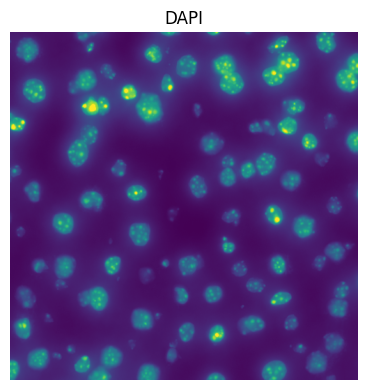

In [3]:
import numpy as np
from harpy.image._image import _get_spatial_element
import dask.array as da
from matplotlib.colors import Normalize

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
channel = "DAPI"
crd = [3000, 4000, 3000, 4000]  # crop is in pixel coordinates
to_coordinate_system = "pixel"

# normalization parameters for visualization (underlying image not changed)
# for visualization we normalize by the 99th percentile
se = _get_spatial_element(sdata, layer=img_layer)
_channel_idx = np.where(se.c.data == channel)[0].item()
vmax = da.percentile(se.data[_channel_idx].flatten(), q=99).compute()
norm = Normalize(vmax=vmax, clip=False)

render_images_kwargs = {"cmap": "viridis", "norm": norm}
show_kwargs = {"title": channel, "colorbar": False}
ax = hp.pl.plot_sdata(
    sdata,
    img_layer=img_layer,
    channel=channel,
    crd=crd,
    to_coordinate_system=to_coordinate_system,
    render_images_kwargs=render_images_kwargs,
    show_kwargs=show_kwargs,
    ax=ax,
)
# frameless figure
ax.axis("off")

plt.tight_layout()
plt.show()

Or plot full image in micron coordinates:

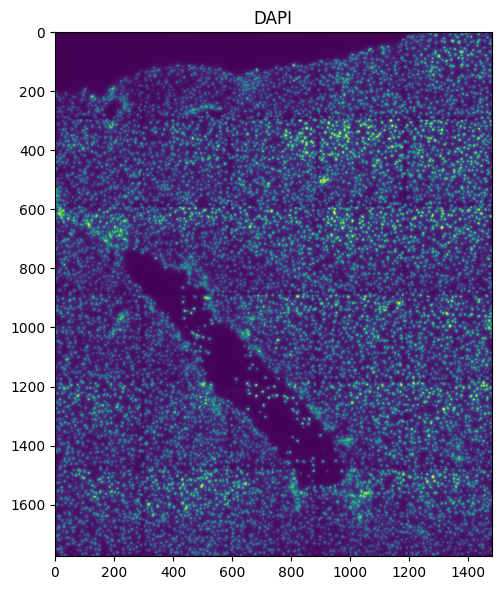

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
channel = "DAPI"
to_coordinate_system = "micron"

render_images_kwargs = {
    "cmap": "viridis",
    "norm": norm,
}
show_kwargs = {
    "title": channel,
    "colorbar": False,
}
ax = hp.pl.plot_sdata(
    sdata,
    img_layer=img_layer,
    channel=channel,
    crd=None,
    to_coordinate_system=to_coordinate_system,
    render_images_kwargs=render_images_kwargs,
    show_kwargs=show_kwargs,
    ax=ax,
)

plt.tight_layout()
plt.show()

Queries can also be done in micron coordinates:

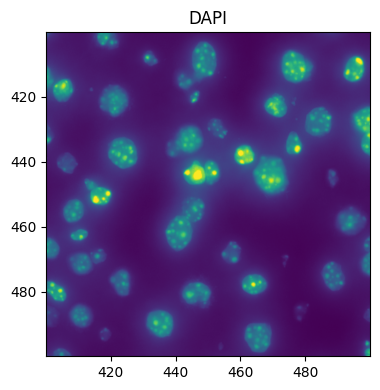

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
channel = "DAPI"
crd = [400, 500, 400, 500]  # crops can also be specified in micron coordinates
to_coordinate_system = "micron"

render_images_kwargs = {"cmap": "viridis", "norm": norm}
show_kwargs = {"title": channel, "colorbar": False}
ax = hp.pl.plot_sdata(
    sdata,
    img_layer=img_layer,
    channel=channel,
    crd=crd,
    to_coordinate_system="micron",
    render_images_kwargs=render_images_kwargs,
    show_kwargs=show_kwargs,
    ax=ax,
)

plt.tight_layout()
plt.show()

## 3. Segment using Cellpose


In [6]:
import torch
from dask.distributed import Client, LocalCluster

if torch.cuda.is_available():
    from dask_cuda import LocalCUDACluster  # pip install dask-cuda

    # One worker per GPU; each worker will be pinned to a single GPU.
    cluster = LocalCUDACluster(
        CUDA_VISIBLE_DEVICES=[0],  # or [0,1],...etc
        n_workers=1,  # 2 if [0,1],...etc
        threads_per_worker=1,
        memory_limit="32GB",
        # local_directory=os.environ.get( "TMPDIR" ),#
    )
else:
    # cpu/mps fall back
    from dask.distributed import LocalCluster

    cluster = LocalCluster(
        n_workers=1
        if torch.backends.mps.is_available()
        else 8,  # If mps/cuda device available, it is better to increase chunk size to maximal value that fits on the gpu, and set n_workers to 1.
        # For this dummy example, we only have one chunk, so setting n_workers>1, has no effect.
        threads_per_worker=1,
        memory_limit="32GB",
        # local_directory=os.environ.get( "TMPDIR" ),
    )

client = Client(cluster)

print(client.dashboard_link)

sdata = hp.im.segment(
    sdata,
    img_layer="raw_image",
    depth=200,
    model=hp.im.cellpose_callable,
    # parameters that will be passed to the callable cellpose_callable
    diameter=50,
    flow_threshold=0.9,
    cellprob_threshold=-4,
    output_labels_layer="segmentation_mask",
    output_shapes_layer="segmentation_mask_boundaries",
    crd=[3000, 4000, 3000, 4000],  # region to segment [x_min, xmax, y_min, y_max], must be defined in pixel coordinates
    to_coordinate_system="pixel",
    overwrite=True,
)
client.close()

http://127.0.0.1:8787/status


/Users/arnedf/VIB/harpy/.venv_harpy/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
pretrained model /Users/arnedf/.cellpose/models/cpsam not found, using default model
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
Resizing is deprecated in v4.0.1+
pretrained model /Users/arnedf/.cellpose/models/cpsam not found, using default model
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
Resizing is deprecated in v4.0.1+
pretrained model /Users/arnedf/.cellpose/models/cpsam not found, using default model
channels deprecated in v4.0.1+. If data contain more tha

## 4. Visualize resulting segmentation

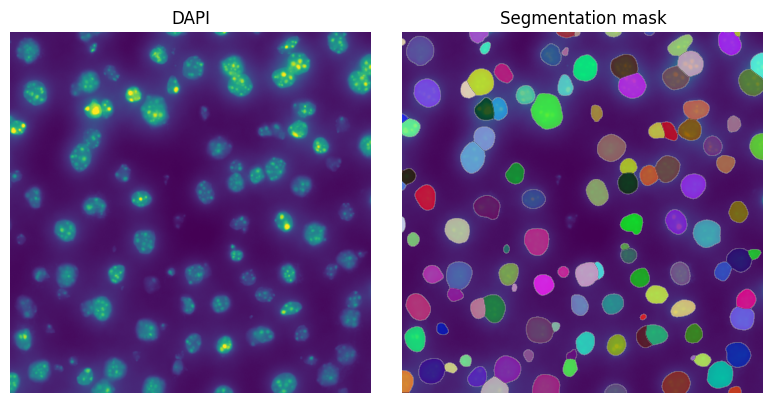

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

channel = "DAPI"
img_layer = "raw_image"
labels_layer = "segmentation_mask"
crd = [3000, 4000, 3000, 4000]  # Crop in pixels. One could also choose to do the crop in micron coordinates
to_coordinate_system = "pixel"

render_images_kwargs = {"cmap": "viridis", "norm": norm}
render_labels_kwargs = {"fill_alpha": 0.6, "outline_alpha": 0.4}
show_kwargs = {"title": channel, "colorbar": False}
_ax = hp.pl.plot_sdata(
    sdata,
    img_layer=img_layer,
    crd=crd,
    to_coordinate_system=to_coordinate_system,
    channel=channel,
    render_images_kwargs=render_images_kwargs,
    show_kwargs=show_kwargs,
    ax=axes[0],
)
_ax.axis("off")

show_kwargs = {"title": "Segmentation mask", "colorbar": False}
_ax = hp.pl.plot_sdata(
    sdata,
    img_layer=img_layer,
    labels_layer=labels_layer,
    crd=crd,
    to_coordinate_system=to_coordinate_system,
    channel=channel,
    render_images_kwargs=render_images_kwargs,
    render_labels_kwargs=render_labels_kwargs,
    show_kwargs=show_kwargs,
    ax=axes[1],
)
_ax.axis("off")

plt.tight_layout()
plt.show()

## 5. Read the transcripts

In [8]:
path_transcripts = registry.fetch("transcriptomics/resolve/mouse/20272_slide1_A1-1_results.txt")
sdata = hp.io.read_resolve_transcripts(
    sdata,
    path_count_matrix=path_transcripts,
    output_layer="transcripts",
    to_coordinate_system="pixel",
    to_micron_coordinate_system="micron",
    pixel_size=pixel_size,
    overwrite=True,
)
sdata

2025-11-19 20:54:48,979 - harpy.io._transcripts - INFO - No transform matrix given, will use identity matrix.
2025-11-19 20:54:48,980 - harpy.io._transcripts - INFO - Transform matrix used:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
2025-11-19 20:54:48,980 - harpy.io._transcripts - INFO - Adding micron coordinate system for transcripts: 'micron'.


SpatialData object, with associated Zarr store: /private/var/folders/q5/7yhs0l6d0x771g7qdbhvkvmr0000gp/T/sdata_21e9705d-6c32-4296-b47c-b06327941efa.zarr
├── Images
│     └── 'raw_image': DataTree[cyx] (1, 12864, 10720), (1, 6432, 5360), (1, 3216, 2680), (1, 1608, 1340), (1, 804, 670)
├── Labels
│     └── 'segmentation_mask': DataArray[yx] (1000, 1000)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 3) (2D points)
└── Shapes
      └── 'segmentation_mask_boundaries': GeoDataFrame shape: (121, 1) (2D shapes)
with coordinate systems:
    ▸ 'micron', with elements:
        raw_image (Images), segmentation_mask (Labels), transcripts (Points), segmentation_mask_boundaries (Shapes)
    ▸ 'pixel', with elements:
        raw_image (Images), segmentation_mask (Labels), transcripts (Points), segmentation_mask_boundaries (Shapes)

2025-11-19 20:54:52,723 - harpy.plot._plot_sdata - INFO - Column 'gene' of 'sdata.points[transcripts]' is of dtype categorical, while 'genes' is 'None'. We proceed with converting to dtype object, to prevent spatialdata-plot to plot all genes as categories. In case of a backed SpatialData object, this will not affect the underlying zarr store, only the in-memory representation of 'sdata.points[transcripts][gene]'.


INFO     Value for parameter 'color' appears to be a color, using it as such.                                      


/Users/arnedf/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


2025-11-19 20:55:01,218 - harpy.plot._plot_sdata - INFO - Column 'gene' of 'sdata.points[transcripts]' is not of dtype categorical, while 'genes' is not 'None'. We proceed with categorizing the column, so spatialdata-plot can plot the genes as categories. In case of a backed SpatialData object, this will not affect the underlying zarr store, only the in-memory representation of 'sdata.points[transcripts][gene]'.
2025-11-19 20:55:01,826 - harpy.plot._plot_sdata - INFO - Plotting column gene of 'sdata.points[transcripts]' as categorical.


INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


/Users/arnedf/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/Users/arnedf/VIB/harpy/.venv_harpy/lib/python3.12/site-packages/dask/dataframe/core.py:3769: UserWarning: Dask currently has limited support for converting pandas extension dtypes to arrays. Converting string to object dtype.
  warnings.warn(
/Users/arnedf/VIB/harpy/.venv_harpy/lib/python3.12/site-packages/dask/dataframe/core.py:3769: UserWarning: Dask currently has limited support for converting pandas extension dtypes to arrays. Converting string to object dtype.
  warnings.warn(


<Axes: title={'center': 'transcripts (in micron)'}>

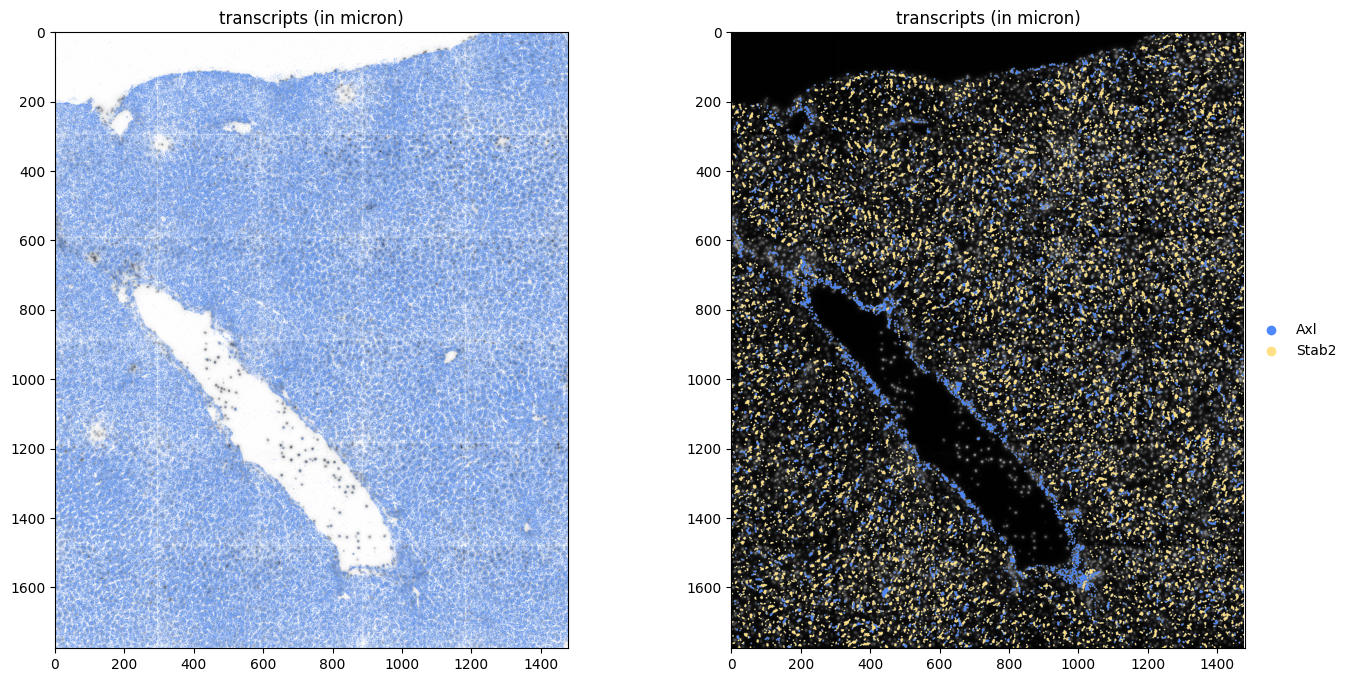

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

render_images_kwargs = {
    "cmap": "binary",
}
show_kwargs = {
    "title": "transcripts (in micron)",
    "colorbar": False,
}

hp.pl.plot_sdata_genes(
    sdata,
    points_layer="transcripts",
    img_layer="raw_image",
    genes=None,  # plot all genes
    color="cornflowerblue",
    size=0.1,
    frac=0.5,  # only plot half of them
    to_coordinate_system="micron",
    show_kwargs=show_kwargs,
    render_images_kwargs=render_images_kwargs,
    ax=axes[0],
)

render_images_kwargs = {
    "cmap": "grey",
}
show_kwargs = {
    "title": "transcripts (in micron)",
    "colorbar": False,
}

hp.pl.plot_sdata_genes(
    sdata,
    points_layer="transcripts",
    img_layer="raw_image",
    genes=["Axl", "Stab2"],
    palette=["#4D88FF", "#FFE082"],
    size=5.0,
    frac=None,
    to_coordinate_system="micron",
    show_kwargs=show_kwargs,
    render_images_kwargs=render_images_kwargs,
    ax=axes[1],
)

Or visualize a crop.

Querying points is slow in spatialdata, therefore, we query the points outside of spatialdata (and therefore also the image).

In [10]:
from spatialdata import bounding_box_query

crd = [3000, 4000, 3000, 4000]

to_coordinate_system = "pixel"  # we query in 'intrinsic' pixel coordinate system

y_start = crd[2]
x_start = crd[0]

y_end = crd[3]
x_end = crd[1]

name_x = "x"
name_y = "y"

y_query = f"{y_start} <={name_y} < {y_end}"
x_query = f"{x_start} <={name_x} < {x_end}"

query = f"{y_query} and {x_query}"

sdata["transcripts"] = sdata["transcripts"].categorize(columns=["gene"])
sdata["transcripts_queried"] = sdata["transcripts"].query(query)

sdata["raw_image_queried"] = bounding_box_query(
    sdata["raw_image"],
    axes=["x", "y"],
    min_coordinate=[crd[0], crd[2]],
    max_coordinate=[crd[1], crd[3]],
    target_coordinate_system=to_coordinate_system,
)

2025-11-19 20:55:09,496 - harpy.plot._plot_sdata - INFO - Plotting column gene of 'sdata.points[transcripts_queried]' as categorical.
/Users/arnedf/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/Users/arnedf/VIB/harpy/.venv_harpy/lib/python3.12/site-packages/spatialdata_plot/pl/render.py:821: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = ax.scatter(


(np.float64(3000.0),
 np.float64(4000.0),
 np.float64(4000.0),
 np.float64(3000.0))

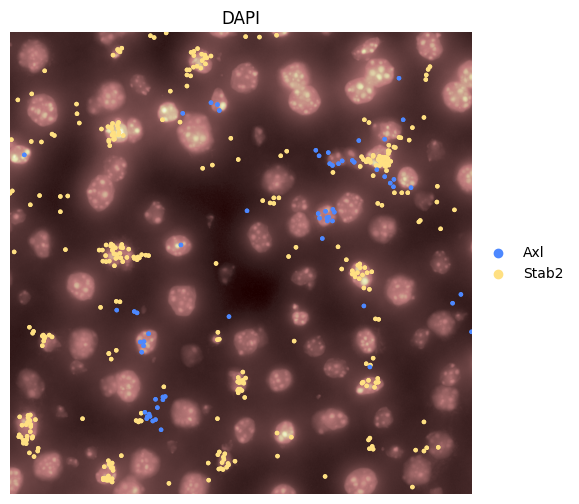

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))

render_images_kwargs = {
    "cmap": "pink",
}
show_kwargs = {
    "title": channel,
    "colorbar": False,
}

hp.pl.plot_sdata_genes(
    sdata,
    points_layer="transcripts_queried",
    img_layer="raw_image_queried",
    genes=["Axl", "Stab2"],
    palette=["#4D88FF", "#FFE082"],
    size=5.0,
    frac=None,
    crd=None,
    to_coordinate_system=to_coordinate_system,
    show_kwargs=show_kwargs,
    render_images_kwargs=render_images_kwargs,
    ax=axes,
)

del sdata["transcripts_queried"]
del sdata["raw_image_queried"]

axes.axis("off")

## 6. Create the AnnData table

In [12]:
# Use dask cluster for optimal processing. For this dummy example, one could also work without a dask cluster.
cluster = LocalCluster(
    n_workers=8,
    threads_per_worker=1,
    processes=True,
    memory_limit="8GB",
    # local_directory=os.environ.get( "TMPDIR" ),
)

client = Client(cluster)

print(client.dashboard_link)

/Users/arnedf/VIB/harpy/.venv_harpy/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 49706 instead
  warnings.warn(


http://127.0.0.1:49706/status


In [13]:
sdata = hp.tb.allocate(
    sdata,
    labels_layer="segmentation_mask",
    points_layer="transcripts",
    output_layer="table_transcriptomics",
    chunks=None,
    to_coordinate_system="pixel",
    update_shapes_layers=False,
    overwrite=True,
)
sdata["table_transcriptomics"]

client.close()

2025-11-19 20:55:15,329 - harpy.image._image - INFO - There seems to be more than one coordinate system defined on the provided spatial element ('['pixel', 'micron']'). We only consider the coordinate sytem specified via parameter 'to_coordinate_system': 'pixel'.
2025-11-19 20:55:15,337 - harpy.table._allocation - INFO - Calculating cell counts.
/Users/arnedf/VIB/harpy/.venv_harpy/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/arnedf/VIB/harpy/.venv_harpy/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. R

In [14]:
sdata["table_transcriptomics"].to_df().head()

,Adamtsl2,Adgre1,Atp6v0d2,Axl,C5ar1,Ccr2,Cd207,Cd209a,Cd36,Cd3e,...,Sox9,Spn,Spon2,Stab2,Timd4,Tmem119,Vsig4,Vwf,Wnt2,Wnt9b
cells,,,,,,,,,,,,,,,,,,,,,
65_segmentation_mask_a6baaa75,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69_segmentation_mask_a6baaa75,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71_segmentation_mask_a6baaa75,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
81_segmentation_mask_a6baaa75,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83_segmentation_mask_a6baaa75,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now visualize the expression of 2 genes:

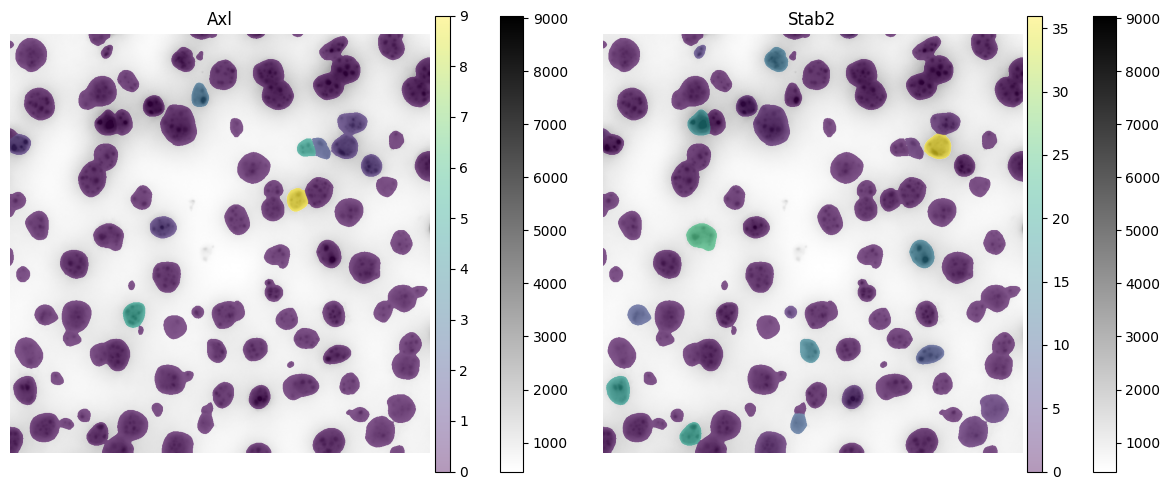

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

channel = "DAPI"
img_layer = "raw_image"
labels_layer = "segmentation_mask"
table_layer = "table_transcriptomics"
crd = [3000, 4000, 3000, 4000]
to_coordinate_system = "pixel"

render_images_kwargs = {"cmap": "binary", "norm": norm}
render_labels_kwargs = {"fill_alpha": 0.6, "outline_alpha": 0.4}

# subset because querying of points is slow, and we do not need them in this visualization
sdata_to_plot = sdata.subset(element_names=[img_layer, labels_layer, table_layer])

color = "Axl"
show_kwargs = {
    "title": f"{color}",
    "colorbar": True,
}
ax = hp.pl.plot_sdata(
    sdata_to_plot,
    img_layer=img_layer,
    channel=channel,
    crd=crd,
    to_coordinate_system=to_coordinate_system,
    labels_layer=labels_layer,
    table_layer=table_layer,
    color=color,
    render_images_kwargs=render_images_kwargs,
    show_kwargs=show_kwargs,
    ax=axes[0],
)
ax.axis("off")

# color by mean intensity
color = "Stab2"
show_kwargs = {
    "title": f"{color}",
    "colorbar": True,
}
ax = hp.pl.plot_sdata(
    sdata_to_plot,
    img_layer=img_layer,
    channel=channel,
    crd=crd,
    to_coordinate_system=to_coordinate_system,
    labels_layer=labels_layer,
    table_layer=table_layer,
    color=color,
    render_images_kwargs=render_images_kwargs,
    show_kwargs=show_kwargs,
    ax=axes[1],
)
ax.axis("off")

plt.tight_layout()
plt.show()

## 6. Leiden Clustering

In [16]:
sdata = hp.tb.preprocess_transcriptomics(
    sdata,
    labels_layer="segmentation_mask",
    table_layer="table_transcriptomics",
    output_layer="table_transcriptomics_preprocessed",
    update_shapes_layers=False,
    overwrite=True,
)

2025-11-19 20:55:22,307 - harpy.table._preprocess - INFO - Calculating cell size from provided labels_layer 'segmentation_mask'
/Users/arnedf/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
2025-11-19 20:55:22,347 - harpy.table._preprocess - INFO - Saving non preprocessed data matrix to '.layers[raw_counts]'.
/Users/arnedf/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
2025-11-19 20:55:22,356 - harpy.table._preprocess - WARNING - amount of pc's was set to 40 because of the dimensionality of 'sdata.tables[table_layer]'.
/Users/arnedf/VIB/harpy/.venv_harpy/lib/python3.12/site-packages/spatialdata/models/models.py:1183: UserWarning: Converting `region_key: fov_labels` to categorical dtyp

In [17]:
sdata = hp.tb.leiden(
    sdata,
    labels_layer="segmentation_mask",
    table_layer="table_transcriptomics_preprocessed",
    output_layer="table_transcriptomics_preprocessed",
    overwrite=True,
)

2025-11-19 20:55:27,313 - harpy.utils._io - WARNING - layer with name 'table_transcriptomics_preprocessed' already exists. Overwriting...


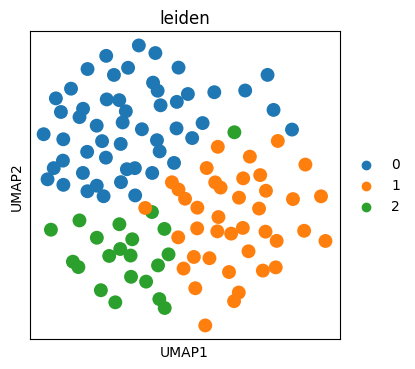

In [18]:
import scanpy as sc

fig, ax = plt.subplots(figsize=(4, 4))

sc.pl.umap(
    sdata["table_transcriptomics_preprocessed"],
    color="leiden",
    size=400,
    ax=ax,
)

(np.float64(3000.0),
 np.float64(4000.0),
 np.float64(4000.0),
 np.float64(3000.0))

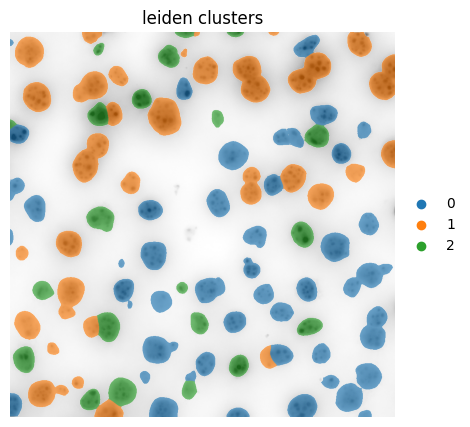

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))

channel = "DAPI"
img_layer = "raw_image"
labels_layer = "segmentation_mask"
table_layer = "table_transcriptomics_preprocessed"
crd = [3000, 4000, 3000, 4000]
to_coordinate_system = "pixel"

render_images_kwargs = {"cmap": "binary", "norm": norm}
render_labels_kwargs = {"fill_alpha": 0.6, "outline_alpha": 0.4}

# subset because querying of points is slow, and we do not need them in this visualization
sdata_to_plot = sdata.subset(element_names=[img_layer, labels_layer, table_layer])

color = "leiden"
show_kwargs = {
    "title": f"{color} clusters",
    "colorbar": False,
}
ax = hp.pl.plot_sdata(
    sdata_to_plot,
    img_layer=img_layer,
    channel=channel,
    crd=crd,
    to_coordinate_system=to_coordinate_system,
    labels_layer=labels_layer,
    table_layer=table_layer,
    color=color,
    render_images_kwargs=render_images_kwargs,
    show_kwargs=show_kwargs,
    ax=axes,
)
ax.axis("off")